In [2]:
import numpy as np
import matplotlib.pyplot as plt
from src.bayes_opt import BayesianOptimization

def kernel(x, y, sigma):
    sqdist = np.sum(x**2, 1).reshape(-1,1) + np.sum(y**2, 1) - 2*np.dot(x, y.T)
    return np.exp(-0.5 * 1/sigma * sqdist)

We don't know the function to explore: so we assume a uniform prior in the  support considered.
Our support is the time in minutes (say 0, 100).

The values are the costs of which are observed from the instantiations of the solver and we will query them later.

For the moment being, we initialize a Kernel (K_ss) which will allow us to express our prior as a multivariate normal distribution.

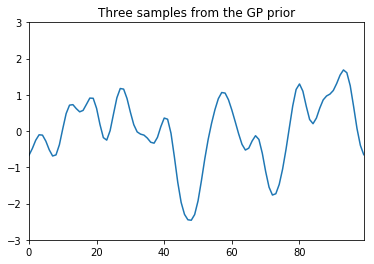

In [16]:
support = [0, 99]
n = 100
Xtest = np.linspace(support[0], support[1], n).reshape(-1,1)

# The parameter denotes the 'smoothness' of our prior
param = 10
K_ss = kernel(Xtest, Xtest, param)      # we estimate K**

# Get cholesky decomposition (square root) of the covariance 
# matrix: I.e., we find L s.t.  L * L^t = K_ss
L = np.linalg.cholesky(K_ss + 1e-10*np.eye(n))

# Now our functions can be expressed as multivariate normal 
# distributions in terms of standard normals: f ~ mu + L * Normal(0,1)

# Sample a standard normal for our test points. We can sample more functions 
# here. Multiply them by the square root of the covariance matrix (L)
f_prior = np.dot(L, np.random.normal(size=(n, 1)))

# Let's see the results
plt.plot(Xtest, f_prior)
plt.axis([support[0], support[1], -3, 3])
plt.title('Three samples from the GP prior')
plt.show()

Now that we have our prior, let's make some observations.

In Bayesian Optimization the observation points are suggested by solving an optimiztion problem which in turn uses an acquisition function such as the Upper Confidence Bound. 
In this example we are not using an update function. We will do that later. 
We assume now that we have queried 5 points for minutes: [1, 4, 25, 30, 85]. The costs associted to those data points are then stored in the yTrain array.

Now let's build a posterior given our prior and these observations.
To do so, we again compute the kernel for this set of points, and build the covariance matrix for its distribution.

In [ ]:
# Noiseless training data
Xtrain = np.array([1, 4, 25, 30, 85]).reshape(5,1)
ytrain = np.array([2, 5,  5, 8, 3]).reshape(5,1)

# Apply the kernel function to our training points
# We estimate K
K = kernel(Xtrain, Xtrain, param)
# The co-variance matrix for the "training" distribution is:
L = np.linalg.cholesky(K + 1e-10*np.eye(len(Xtrain)))

We can now estimate the compute the mean value at our initial test points.

Finally, using these mean values, we can draw samples from the posterior at our test points. 

Notice that data points in the plot will match the values in our training test and the prior distribution will be modified accordingly.

Now we can continue with this process by querying new points.



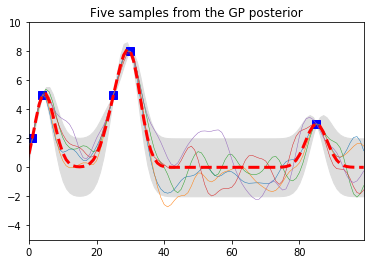

In [28]:
# Compute the mean at our test points.

# We estimate K*:
K_s = kernel(Xtrain, Xtest, param)      
# We solve tLkhe  Ax = b (where A is L (the co-variance matrix of the training distr.),
#  and b is K*)

Lk = np.linalg.solve(L, K_s)

# The mean at the test points is:
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)

# Draw samples from the posterior at our test points
L = np.linalg.cholesky(K_ss + 1e-10*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n, 5)))

plt.plot(Xtrain, ytrain, 'bs', ms=8)
# the posterior curves
plt.plot(Xtest, f_post, lw=0.5)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
#The posterior mean
plt.plot(Xtest, mu, 'r--', lw=3)
plt.axis([support[0], support[1], -5, 10])
plt.title('Five samples from the GP posterior')
plt.show()